In [1]:
import numpy as np
import nengo
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

In [2]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = f"./../../Data Extraction/Extracted Data/{monkey}_raw.csv"   

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# velocity data
velocity_matrix = df[["x_velocity", "y_velocity"]]
# acceleration data
acceleration_matrix = df[["x_acceleration", "y_acceleration"]]

# transpose the data
activity_matrix_t = activity_matrix.transpose().to_numpy()
velocity_matrix_t = velocity_matrix.transpose().to_numpy()
acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()

['Unnamed: 0', 'x_position', 'y_position', 'x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration', 'time_stamps', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'Neuron50', 'Neuron51', 'Neuron52', 'Neuron53', 'Neuron54', 'Neuron55', 'Neuron56', 'Neuron57', 'Neuron58', 'Neuron59', 'Neuron60', 'Neuron61', 'Neuron62', 'Neuron63', 'Neuron64', 'Neuron65', 'Neuron66', 'Neuron67', 'Neuron68', 'Neuron69', 'Neuron70', 'Neuron71', 'Neuron72', 'Neuron73', 'Neuron74',

In [4]:
num_rows= activity_matrix.shape[0]
num_columns= activity_matrix.shape[1]
print("The number of rows" , num_rows)
print("The number of rows" , num_columns)

num_neurons= num_columns
print(num_neurons)

The number of rows 1066001
The number of rows 94
94


In [5]:
spikes = activity_matrix_t
scalar = np.max(acceleration_matrix_t)
target_out = acceleration_matrix_t/scalar 

In [6]:
spikes.shape

(94, 1066001)

In [7]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

from utils.LMU_Stack import LMUStack

In [8]:
from collections import deque

#synapses - act as filters or delays that are then applied to neural connections
#purpose of this class --> any signal passing through this synapse will be delayed by 200 ms
#ideal delay is a synapse that has been customed so that it delays the signal without filtering

class IdealDelay(nengo.synapses.Synapse):
    def __init__(self,delay):
        super().__init__()
        #stored delay value 
        self.delay= delay

    #sets up the delayed processing of the input signals
    def make_state(self,shape_in, shape_out, dt, dtype=None, y0=None):
        return{}
    
    #function makes a delated output function that stores past inputs
    def make_step(self, shape_in, shape_out, dt, rng, state):
        #deque = double-ended queue that allows insertion and removal of elements from BOTH ends (front and back)
        #delay buffer to store past inputs before they are output
        buffer= deque([0]*int(self.delay/dt)) 
    
        #processes the input x at time t 
        def delay_func(t,x):
            #appends at the end (the right)
            #stores newest input at the end of the queue

            buffer.append(x.copy())

            #appends at the front 
            #removes the oldest stored value from the front of the queue
            #returns the oldest value from deque (the first value)
            #FIFO (first in first out) - simulating delays
            return buffer.popleft()
        return delay_func

In [28]:
# Model Parameters
n_ensemble_neurons = 500
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 0.025
probe_synapse = 0.01
running_time = 100
training_time = 0.8*running_time # WHen does the model stop learning
dt= 0.001

In [35]:
dimensions = num_neurons
out_dimension= 2
num_degree= 2
neurons= 500
proj_dim = 2

In [36]:
with nengo.Network() as model:
    input_node= nengo.Node(lambda t:spikes[:,int(t / dt) - 1])
    lmu_set= LMUStack(proj_dim, order= num_degree)
    print(lmu_set.input.size_in)
    print(lmu_set.output.size_out)

    ##Where each of the channels from the input node (94 dims) are being mapped to individual neurons that contribute in varying amounts to each output dimension (10 dims in this case)
    representation_ensemble= nengo.Ensemble(n_neurons=spikes.shape[0],dimensions=10 )

    target_node = nengo.Node(lambda t: target_out[:,int(t/dt)-1])
    inhib_node= nengo.Node(output=lambda t: t>=training_time)

    intermediate_ens= nengo.Ensemble(dimensions*num_degree*2, proj_dim*num_degree) #
    out_ens = nengo.Ensemble(n_ensemble_neurons, out_dimension, ensemble_radius)
    err_ens = nengo.Ensemble(n_ensemble_neurons, out_dimension, ensemble_radius)

    in_rep_ens_connection=  nengo.Connection(input_node, representation_ensemble.neurons, synapse=0.01)
    rep_lmu_connection = nengo.Connection(representation_ensemble, lmu_set.input, transform=np.random.normal(0,1,(proj_dim, 10)))

    lmu_intermediate_connection = nengo.Connection(lmu_set.output, intermediate_ens )
    learning_connection= nengo.Connection(intermediate_ens, out_ens, function= lambda x:[0,0], learning_rule_type=nengo.PES(learning_rate= 2e-4))

    nengo.Connection(out_ens, err_ens)

    nengo.Connection(err_ens, learning_connection.learning_rule)
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) 

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)


with nengo.Simulator(model, seed=0) as sim:
    sim.run(running_time)





2
4
Build finished in 0:00:01.                                                      
Simulation finished in 0:00:18.                                                 


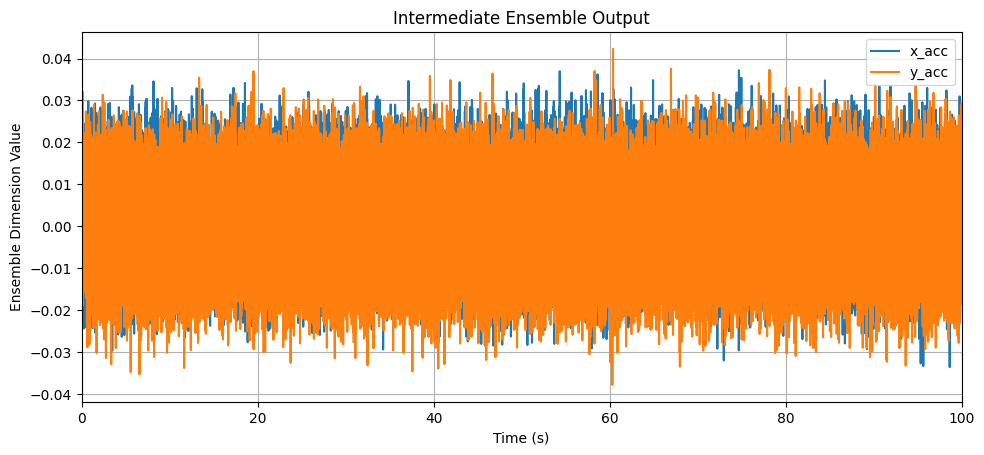

In [37]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

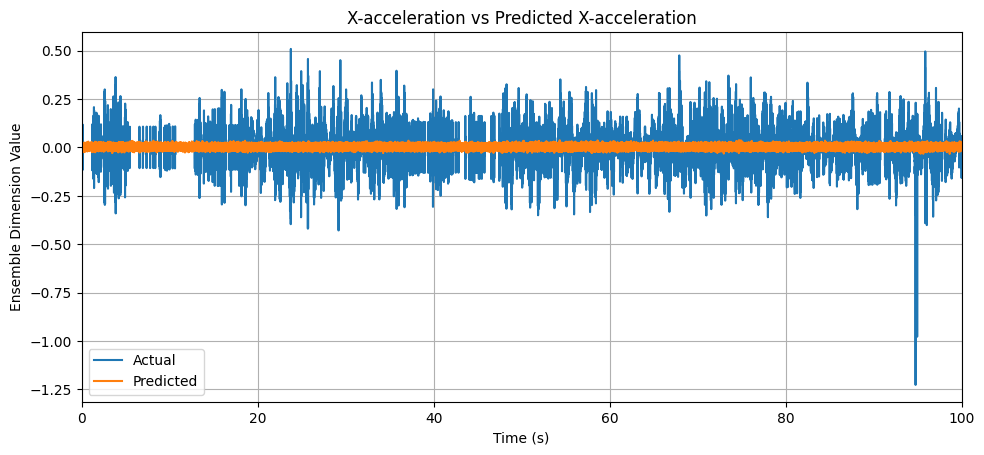

In [40]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

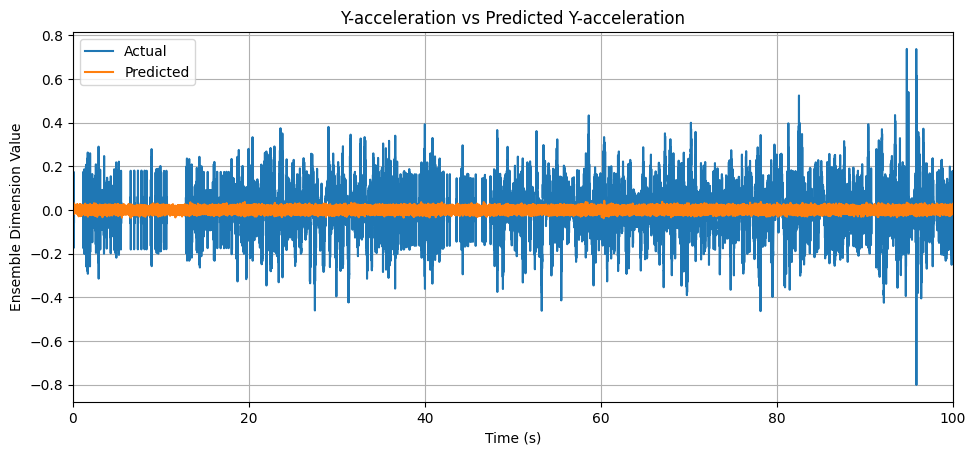

In [39]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

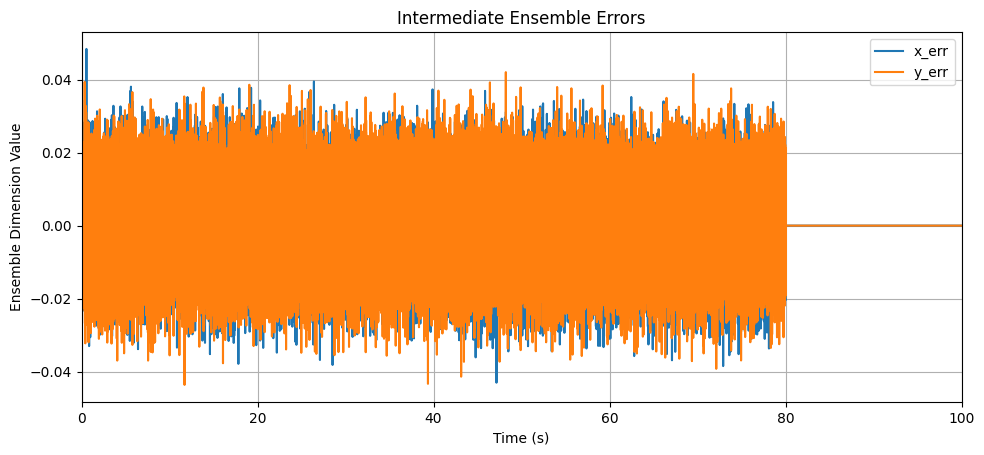

In [34]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

In [16]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [17]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.032343371498569196
Root Mean_Squared Error: 0.05292316242484482

Y-Acceleration Error
Mean Absolute Error: 0.04447955223336516
Root Mean_Squared Error: 0.0767362076578335

